# Exercício 1

## Enunciado

Seja o seguinte problema de propagação de calor transiente por condução em uma barra (Problema de valor inicial e contorno em um domínio unidimensional):

$$
\rho c \dfrac{\partial T}{\partial t} - \kappa \dfrac{\partial ^2 T}{\partial x^2} = 0
$$

Com as seguintes condições iniciais e de contorno:

$$
T(x,t = 0) = 200ºC \\
\dfrac{\partial T}{\partial x} (x=0, t) = 0 \\
T(x = L,t) = 0ºC
$$

A solução analítica deste problema é dada por:

$$
T(x,t) = \dfrac{200 \cdot 4}{\pi} \cdot \sum^m _{n=1} \dfrac{(-1)^{n+1}}{2n - 1} \cdot \exp{(-\alpha \lambda ^2 _n t)} \cdot \cos{(\lambda_n x)}
$$

Onde:

* $\lambda _n = \frac{(2n-1) \cdot \pi}{2L}$ são os autovalores da solução exata.
* $\alpha = \frac{\kappa}{\rho c}$ é o coeficiente de difusividade térmica.

Consideramos as seguintes propriedades físicas:

* $\kappa = 10 * q \frac{W}{m \cdot K}$ é o coeficiente de condutividade térmica.
* $L = 2 cm$ é o comprimento do domínio.
* $\rho c = 10^6 * q \frac{J}{m^3 \cdot K}$ é a capacidade calorífica por unidade de volume do material que constitue a barra.

A variável $q$ é dada por

$$
q = 10 + \dfrac{N - 1}{20}
$$

onde $N = 1$.

Resolver este problema pelo método dos elementos finitos empregando interpolações lineares utilizando uma discretização espacial com uma malha de 3 elementos de mesmo comprimento. Para a solução no tempo utilize o método da diferença central usando passo de tempo o valor de $\Delta t = 1s$. Compare gráficamente (no mesmo gráfico!) as soluções numéricas com a solução exata para os tempos $t = 80s$, $t = 100s$ e $t = 120s$.



## Resolução

### Discretização Espacial

Vamos dividir o domínio (a barra de comprimento $L$) em 3 elementos de mesmo comprimento. Cada elemento terá dois nós, um em cada extremidade.


### Formulação do Método dos Elementos Finitos

#### Função de Interpolação

Para cada elemento, usamos funções de interpolação lineares $N_i​(x)$ para representar a temperatura $T$ dentro do elemento:

$$
T(x) = \sum^n _{i=1} N_i (x) T_i
$$

onde $n$ é o número de nós por elemento e $T_i$ é temperatura e no nó $i$.

#### Montagem da Equação de Elemento

Para cada elemento, aplicamos a equação diferencial. Através da integração por partes (ou método dos resíduos ponderados), obtemos a formulação fraca do problema. Para um elemento genérico, temos:

$$
\int_{x_{e-1}}^{x_e} \rho c N_i \rho \dfrac{\partial T}{\partial t} dx + \int_{x_{e-1}}^{x_e} \kappa \dfrac{\partial N_i}{\partial x} \dfrac{\partial T}{\partial x} dx = 0
$$


#### Montagem da Matriz Global

As equações dos elementos individuais são então montadas em uma matriz global que representa o sistema inteiro.

#### Aplicação das Condições de Contorno

As condições de contorno são aplicadas na matriz global. A condição $T(x=L, t) = 0ºC$ é uma condição de Dirichlet e é aplicada diretamente na matriz. A condição $\dfrac{\partial T}{\partial x} (x=0, t) = 0$ é uma condição de Neumann e afeta a formulação da equação de elemento do nó correspondente.


In [25]:
# Dados do problema
N = 1
q = 10 + (N - 1) / 20

# Propriedades físicas
kappa = 10 * q  # W/(m.K)
rho_c = 10**6 * q  # J/(m^3.K)

kappa, rho_c


(100.0, 10000000.0)

In [26]:
# Comprimento do domínio (em metros)
L = 2 / 100  # 2 cm convertido para metros

# Número de elementos e nós
num_elements = 3
num_nodes = num_elements + 1

# Comprimento de cada elemento
element_length = L / num_elements

# Posições dos nós
node_positions = [i * element_length for i in range(num_nodes)]
node_positions


[0.0, 0.006666666666666667, 0.013333333333333334, 0.02]

### Cálculo das Matrizes Globais

As matrizes globais de massa $M$ e rigidez $K$ para o sistema são:

Matriz de massa $M$:

\begin{bmatrix}
22222.22 & 11111.11 & 0 & 0 \\
11111.11 & 44444.44 & 11111.11 & 0 \\
0 & 11111.11 & 44444.44 & 11111.11 \\
0 & 0 & 11111.11 & 22222.22
\end{bmatrix}


Matriz de rigidez $K$:

\begin{bmatrix}
15000 & -15000 & 0 & 0 \\
-15000 & 30000 & -15000 & 0 \\
0 & -15000 & 30000 & -15000 \\
0 & 0 & -15000 & 15000
\end{bmatrix}


In [27]:
import numpy as np

# Função para criar as matrizes de massa e rigidez para um elemento
def create_element_matrices(length, kappa, rho_c):
    M_element = (rho_c * length / 6) * np.array([[2, 1], [1, 2]])  # Matriz de massa
    K_element = (kappa / length) * np.array([[1, -1], [-1, 1]])    # Matriz de rigidez
    return M_element, K_element

# Inicialização das matrizes globais
M_global = np.zeros((num_nodes, num_nodes))
K_global = np.zeros((num_nodes, num_nodes))

# Montagem das matrizes globais
for i in range(num_elements):
    M_element, K_element = create_element_matrices(element_length, kappa, rho_c)
    
    # Adicionando à matriz global
    M_global[i:i+2, i:i+2] += M_element
    K_global[i:i+2, i:i+2] += K_element

M_global, K_global


(array([[22222.22222222, 11111.11111111,     0.        ,     0.        ],
        [11111.11111111, 44444.44444444, 11111.11111111,     0.        ],
        [    0.        , 11111.11111111, 44444.44444444, 11111.11111111],
        [    0.        ,     0.        , 11111.11111111, 22222.22222222]]),
 array([[ 15000., -15000.,      0.,      0.],
        [-15000.,  30000., -15000.,      0.],
        [     0., -15000.,  30000., -15000.],
        [     0.,      0., -15000.,  15000.]]))

In [28]:
# Condições iniciais
T_initial = 200  # Temperatura inicial em graus Celsius
T = np.full(num_nodes, T_initial)

# Condição de contorno: T(L, t) = 0°C
T[-1] = 0

# Passo de tempo
delta_t = 1  # segundo

# Método da diferença central: (M + delta_t/2 * K) * T_new = (M - delta_t/2 * K) * T_old
# Como as condições de contorno não mudam com o tempo, elas são aplicadas apenas uma vez
A = M_global + delta_t/2 * K_global
B = M_global - delta_t/2 * K_global

# Resolvendo a equação para o próximo passo de tempo
# Consideramos um único passo de tempo para este exemplo
T_new = np.linalg.solve(A, B @ T)

T_new


array([199.57444011, 203.50268528, 142.76597144, 107.88824646])

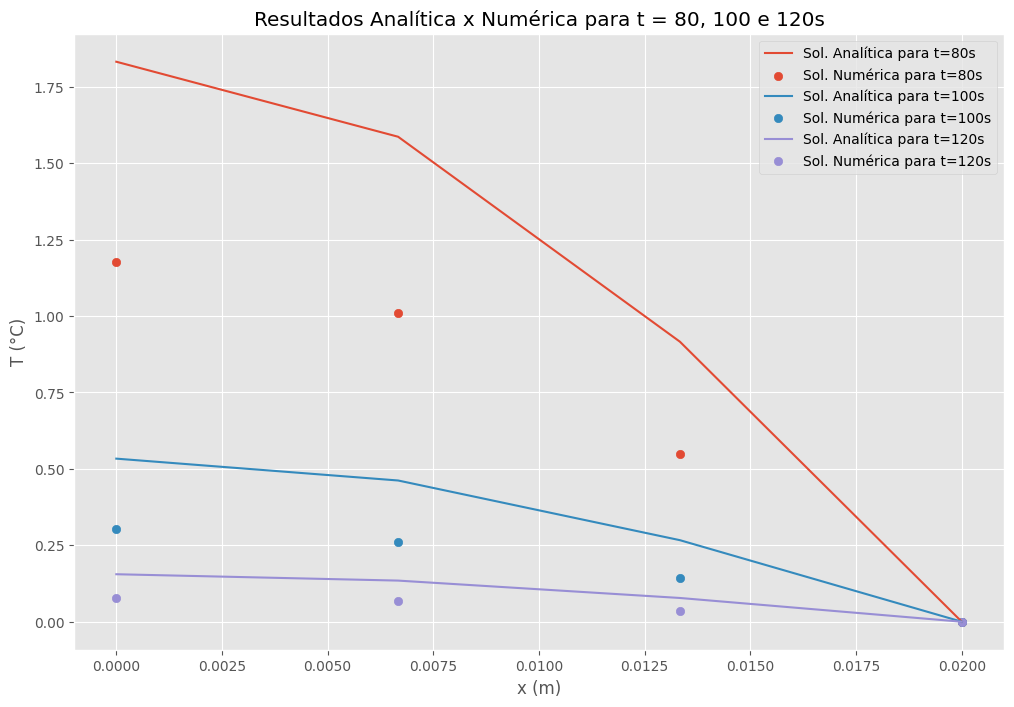

In [37]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Função para calcular a solução analítica
def analytical_solution(x, t, kappa, rho_c, L, m=3):
    alpha = kappa / rho_c
    summation = sum(((-1)**(n+1)) / (2*n - 1) * np.exp(-alpha * ((2*n - 1) * np.pi / (2 * L))**2 * t) * 
                    np.cos((2*n - 1) * np.pi * x / (2 * L)) for n in range(1, m+1))
    return 200 * 4/np.pi * summation

# Tempos específicos
times = [80, 100, 120]

# Solução numérica para cada tempo
T_numerical = {time: np.full(num_nodes, T_initial) for time in times}

for time in times:
    for _ in range(int(time/delta_t)):  # Avançando no tempo
        T_numerical[time] = np.linalg.solve(A, B @ T_numerical[time])
        T_numerical[time][-1] = 0  # Aplicando a condição de contorno

# Solução analítica para cada tempo e posição
x_values = np.arange(0, L + L/3, L/3)  # Valores de x para plotagem
T_analytical = {time: [analytical_solution(x, time, kappa, rho_c, L, m=3) for x in x_values] for time in times}

# Plotando as soluções
plt.figure(figsize=(12, 8))

for time in times:
    plt.plot(x_values, T_analytical[time], label=f'Sol. Analítica para t={time}s')
    plt.scatter(node_positions, T_numerical[time], label=f'Sol. Numérica para t={time}s', marker='o')

plt.title('Resultados Analítica x Numérica para t = 80, 100 e 120s')
plt.xlabel('x (m)')
plt.ylabel('T (°C)')
plt.legend()
plt.grid(True)
plt.show()
